In [53]:
import pandas as pd
import numpy as np

from statsmodels.stats.weightstats import ztest

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown


sns.set(rc={"figure.dpi":200, 'savefig.dpi':200})
sns.set_context('notebook')
sns.set_style("ticks")

In [54]:
df = pd.read_csv("../data/raw/train.csv")

In [55]:
def appendTitle(df):
    df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
    patterns = (
        ['Rev'],
        ['Don', 'Countess', 'Sir', 'Lady', 'Jonkheer'],
        ['Col', 'Capt','Major'],
        ['Mlle','Mme', 'Ms'],
        ['Master', 'Dr']
    )
    titles = (
        'Cleric', 'Noble', 'Military', 'Miss', 'Academic'
    )
    for pattern, title in zip(patterns, titles):
        df['Title'] = df['Title'].replace(pattern, title)
    df['HighSociety'] = df['Title'].isin(['Cleric', 'Noble', 'Miss'])
appendTitle(df)

# 1 Dataset inspection

-   Should we worry about computational complexity? (No, small dataset and small number of features)

-   Should we use sampling techniques to reduce the size of the dataset? (No)


In [56]:
def display_df_memory_usage(df):
    """
    Display the memory usage of a dataframe.    
    """  
    md_table_str = '|Column Name|Size (MB)|\n|---|---|\n'
    mem_mb_total = 0
    for col_name, mem_bytes in df.memory_usage(deep=True).items():
        mem_mb = mem_bytes / 1024**2
        mem_mb_total += mem_mb
        md_table_str += '|{}|{:.2f}|\n'.format(col_name, mem_mb)
    md_table_str += '|Total|{:.2f}|\n'.format(mem_mb_total)
    display(Markdown(md_table_str))
display_df_memory_usage(df)

|Column Name|Size (MB)|
|---|---|
|Index|0.00|
|PassengerId|0.01|
|Survived|0.01|
|Pclass|0.01|
|Name|0.07|
|Sex|0.05|
|Age|0.01|
|SibSp|0.01|
|Parch|0.01|
|Ticket|0.05|
|Fare|0.01|
|Cabin|0.03|
|Embarked|0.05|
|Title|0.05|
|HighSociety|0.00|
|Total|0.36|


# 1-2 Conclusion:

-   We're working with a small dataset. Thus we can use all the data without worrying about computational resources or sampling the data.


# 2 Data Quality Checks

-   Are there too many missing values? (Just in some columns)
-   Any there any columns with many values missing? (Yes, cabin)
-   Should we drop any columns? (Maybe, cabin)
-   Are there duplicate values? (No)
-   Any there strange behavior or corelation in the data? (No, it's seems to be ok. But we should investigate with more sophisticated methods)
    -   At first glance, we can think that the embarked port affect the survival rate. But the initial analysis showed that maybe it's not the case.
    -   Survival rate it seems correlated with the Pclass
-   Should we stop the analysis? (No, we should continue)


In [57]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
 12  Title        891 non-null    object 
 13  HighSociety  891 non-null    bool   
dtypes: bool(1), float64(2), int64(5), object(6)
memory usage: 91.5+ KB


In [58]:
# create a series with the percentage of missing values for each column
missing_values = df.isnull().sum() / len(df)*100
missing_values = missing_values.sort_values(ascending=False)
missing_values.rename("% missing values", inplace=True)
display(Markdown('**Missing values**'))
display(Markdown(missing_values.to_markdown()))
del missing_values

**Missing values**

|             |   % missing values |
|:------------|-------------------:|
| Cabin       |          77.1044   |
| Age         |          19.8653   |
| Embarked    |           0.224467 |
| PassengerId |           0        |
| Survived    |           0        |
| Pclass      |           0        |
| Name        |           0        |
| Sex         |           0        |
| SibSp       |           0        |
| Parch       |           0        |
| Ticket      |           0        |
| Fare        |           0        |
| Title       |           0        |
| HighSociety |           0        |

In [59]:
# print a markdown table with the col , the number of unique values and the unique values list

def unique_values_table(df):
    """Print a markdown table
    with the col, the number of unique values and the unique values 
    list if there are more than 4 unique values.
    """
    md_table_str = '|Column Name|Unique Values||\n|---|---|---|\n'
    for col_name, unique_values in df.nunique().items():
        if unique_values > 3:
            md_table_str += '|{}|{}|\n'.format(col_name, unique_values)
        else:
            md_unique_str = ' '.join([
                f'{name}: {value*100:.1f}\%'
                for name, value in 
                df[col_name].value_counts(normalize=True).items()
            ])

            md_table_str += '|{}|{}|{}\n'.format(
                col_name, unique_values, md_unique_str)
    display(Markdown(md_table_str))
unique_values_table(df)


|Column Name|Unique Values||
|---|---|---|
|PassengerId|891|
|Survived|2|0: 61.6\% 1: 38.4\%
|Pclass|3|3: 55.1\% 1: 24.2\% 2: 20.7\%
|Name|891|
|Sex|2|male: 64.8\% female: 35.2\%
|Age|88|
|SibSp|7|
|Parch|7|
|Ticket|681|
|Fare|248|
|Cabin|147|
|Embarked|3|S: 72.4\% C: 18.9\% Q: 8.7\%
|Title|7|
|HighSociety|2|False: 77.9\% True: 22.1\%


In [60]:
# check for duplicate rows
display(Markdown('**Duplicate rows**'))
display(Markdown(f'{df.duplicated().sum()} duplicate rows'))

**Duplicate rows**

0 duplicate rows

In [61]:
# drop PassengerId column
df.drop(columns=['PassengerId'], inplace=True)
df.drop(columns=['Name'], inplace=True)
df.drop(columns=['Ticket'], inplace=True)

In [62]:
df.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


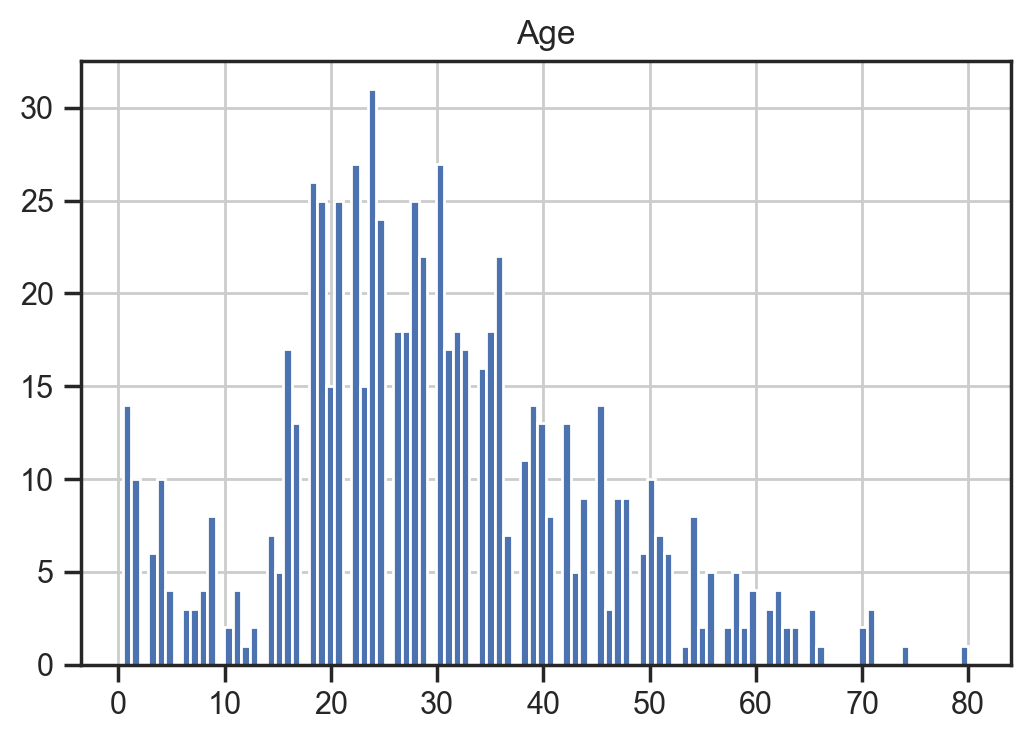

In [63]:
df.hist('Age', bins=100)
plt.show()

-   The `Age` feature distribution seems to be skewed. We should take this into account if we will perform any kind of replacement of missing values.

-   The values are between 0 and 80 which seems to be a reasonable range.


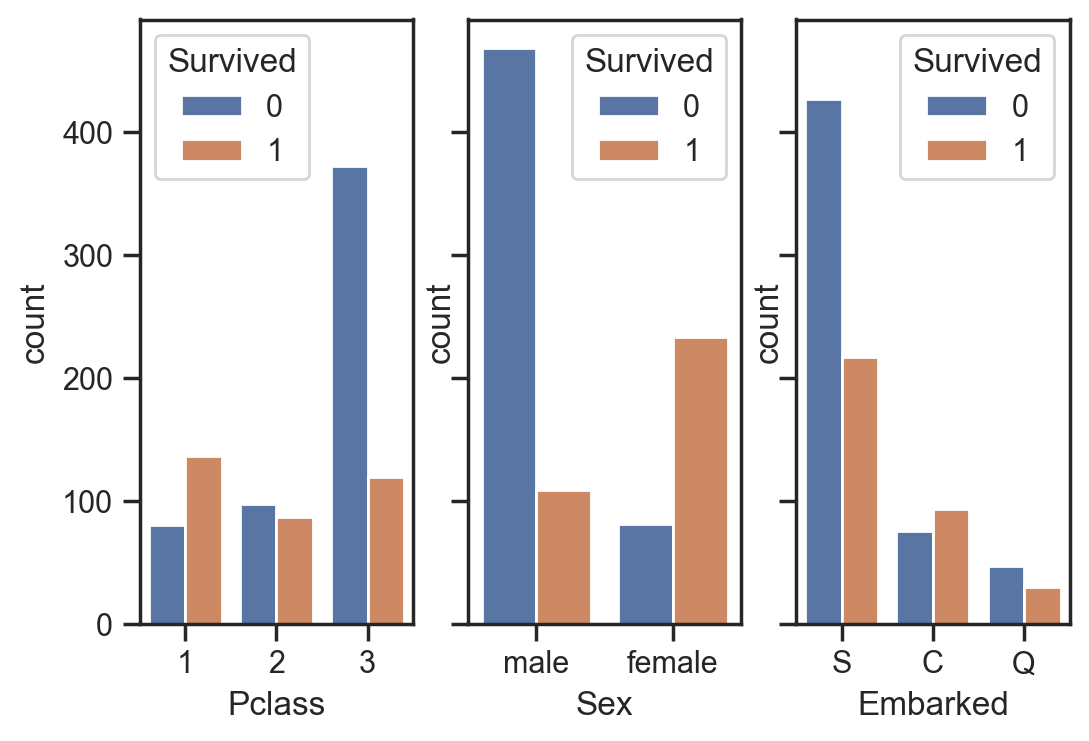

In [65]:
fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True)
for a, col in zip(axes, ['Pclass', 'Sex', 'Embarked']):
    sns.countplot(x=col ,hue='Survived',data=df, ax=a)
plt.show()

-   The `Pclass` seems to affect the survival rate. Which seems reasonable.

-   The discrepancy between female/male rates can be related to the code of conduct
    "_Women and children first_". However, we must to investigate this better. Because this discrepancy can be caused by other factors.

-   At first glance it seems that the passenger that embarked in the `S` point are more likely to die. Obviously, is unrealistic that where the passenger chose to embark affect the chance of survival.
    -   Almost $72\%$ of the passengers embarked at the S point.


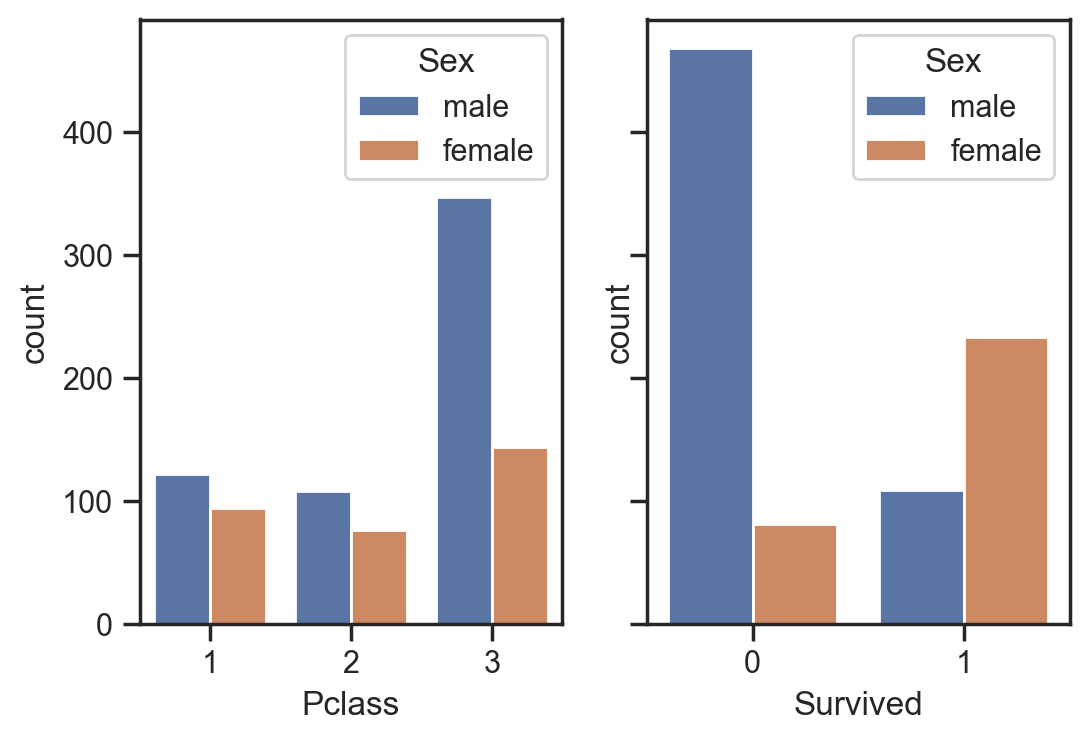

In [66]:

fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True)
for a, col in zip(axes, ['Pclass', 'Survived']):
    sns.countplot(x=col ,hue='Sex',data=df, ax=a)
plt.show()

-   We can notice that the third class is composed mostly of male passengers. So perhaps the discrepancy in survival rates between male and female passengers could be also related to this. We must investigate this more carefully.


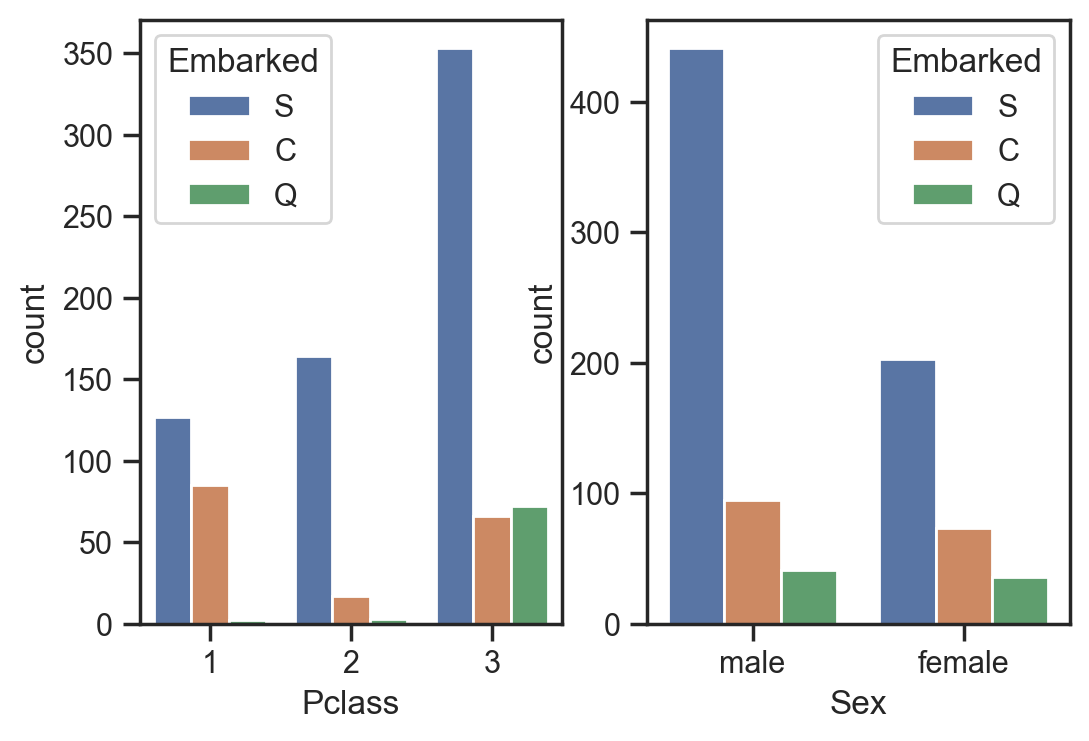

In [67]:
fig, axes = plt.subplots(nrows=1, ncols=2)
for a, col in zip(axes, ['Pclass', 'Sex']):
    sns.countplot(x=col ,hue='Embarked',data=df, ax=a)
plt.show()

In [68]:
def show_dist_table(
    df, col_a='Embarked', col_b='Pclass',
    col_by='Pclass', how='count'
):
    sce = df[
        [col_a, col_b]].groupby(
            [col_a, col_b]
        ).agg(
            {col_by: how}
        )

    sce['Percentage'] = sce.groupby(
            level=0
        ).apply(
            lambda x: 100 * x / float(x.sum())
        )
    sce['Percentage'] = sce['Percentage'].map(
            lambda x: f'{x:.1f}%')
    return sce 

show_dist_table(df)

Pclass Percentage
Embarked Pclass                   
C        1           85      50.6%
         2           17      10.1%
         3           66      39.3%
Q        1            2       2.6%
         2            3       3.9%
         3           72      93.5%
S        1          127      19.7%
         2          164      25.5%
         3          353      54.8%

-   We can notice that mostly of the passengers that emabrked in the `S` point came from the third class.
-   The `Q` point also has a higher rate of third class of passengers. But there is a diffrence because contrary to the `S` point, the number of passengers that embarked in the `Q` point is much lower.


Let's take a look at the `Age` feature distribution.


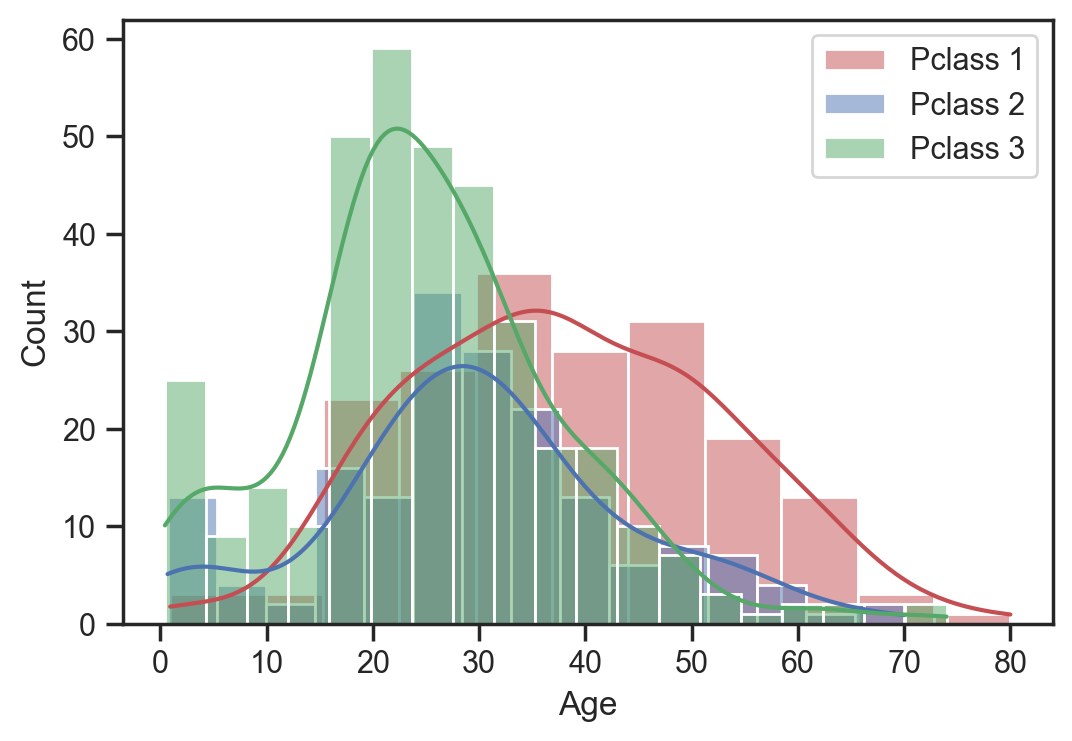

In [69]:
# plot histogram of age by Pclass
plt.figure()
for c, col in zip(('r', 'b', 'g'), [1, 2, 3]):
    df_age = df[df['Pclass'] == col]['Age']
    sns.histplot(df_age, label=f'Pclass {col}', kde=True, color=c)
plt.legend()
plt.show()

In [70]:
(df[df['Pclass'] == 1]['Age'].describe(), df[df['Pclass'] == 2]['Age'].describe())  

(count    186.000000
 mean      38.233441
 std       14.802856
 min        0.920000
 25%       27.000000
 50%       37.000000
 75%       49.000000
 max       80.000000
 Name: Age, dtype: float64,
 count    173.000000
 mean      29.877630
 std       14.001077
 min        0.670000
 25%       23.000000
 50%       29.000000
 75%       36.000000
 max       70.000000
 Name: Age, dtype: float64)

-   The first class passengers are older than the second and third class. We know that the first class passengers has a higher chance of survival than the second and third class.


In [71]:
def z_test(df, col='Age'):
    df_survivors = df[df['Survived'] == 1][col].dropna()
    df_nonsurvivors = df[df['Survived'] == 0][col].dropna()

    t_stat, p_value = ztest(df_survivors, df_nonsurvivors)
    print("Z Test")
    print(20*'-')
    print(f"T stat. = {t_stat:.3f}")
    print(f"P value = {p_value:.3f}\n") 
    print(20*'=')
     
z_test(df)

Z Test
--------------------
T stat. = -2.067
P value = 0.039



According with the z-test the `Age` feature distribution of survived passengers is different from the `Age` feature distribution of non-survived passengers by a p-value lower than 0.05. Howerver, we should take care with this result. The code below shows the `NaN` values in the `Age` feature are not uniformly distributed. Which can be a sign of a problem using statistical tests in this case.

In [72]:
df2=df.copy()
df2['AgeIsNan'] = df2['Age'].isna()
show_dist_table(df2, 'AgeIsNan')

Pclass Percentage
AgeIsNan Pclass                   
False    1          186      26.1%
         2          173      24.2%
         3          355      49.7%
True     1           30      16.9%
         2           11       6.2%
         3          136      76.8%

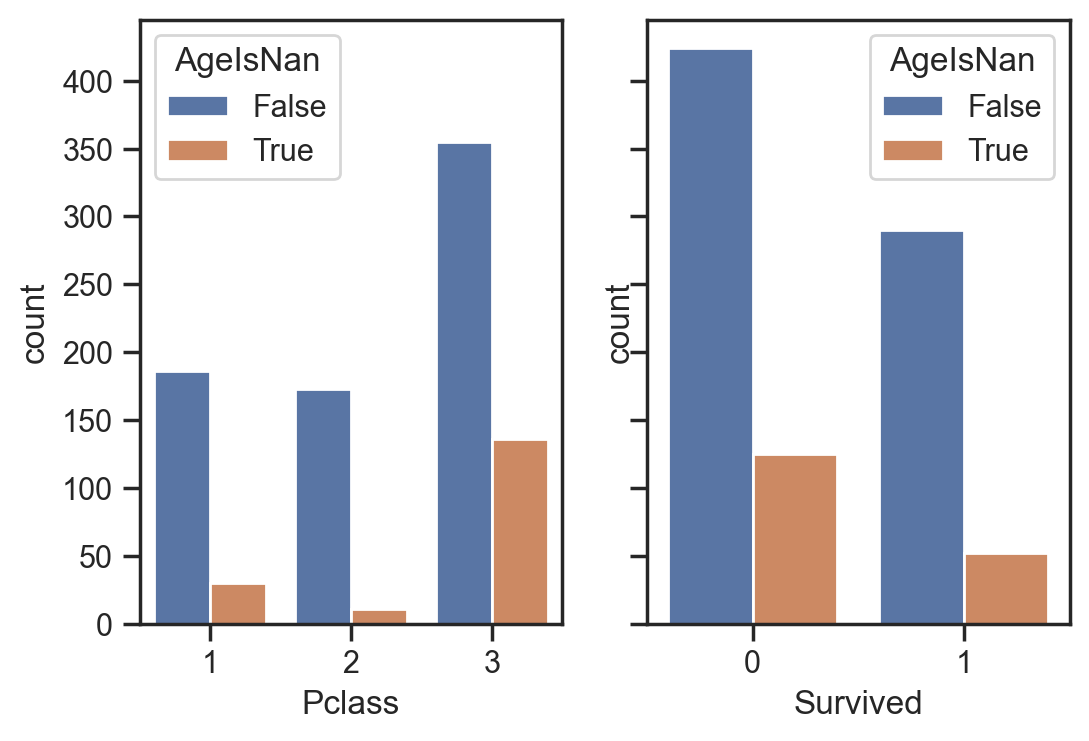

In [128]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True)
for a, col in zip(axes, ['Pclass', 'Survived']):
    sns.countplot(x=col ,hue='AgeIsNan',data=df2, ax=a)
plt.show()

## SHAP and a Baseline Model

In [73]:
import xgboost
import shap 
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.metrics import confusion_matrix
from collections import Counter

shap.initjs()

In [132]:

def plot_confusion_matrix(y_test, y_predicted):
    classNames = ['Negative','Positive']
    cm = confusion_matrix(
        y_test, y_predicted, normalize='all')

    plt.figure(dpi=80)
    plt.imshow(cm, interpolation='nearest', cmap='viridis')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation=45)
    plt.yticks(tick_marks, classNames)

    s = [['TN','FP'], ['FN', 'TP']]
    for i in range(2):
        for j in range(2):
            plt.text(j,i, f"{s[i][j]} = {cm[i][j]*100:.2f}%", color='white')
    plt.show()

def xgb_titanic(
    df0, test_size=0.3, 
    remove_cols=['Embarked', 'Cabin', 'Title', 'HighSociety', ],
    xgb_params={},
    knn_input=False,
    random_state=42,
    ):
    df = df0.copy()
    df['Sex'].replace(['male', 'female'],[0, 1], inplace=True)

    if knn_input:
        imputer = KNNImputer()
        df[['Pclass','Sex','Age']]= imputer.fit_transform(
            df[['Pclass','Sex','Age']])

    features = [
        c 
        for c in df.columns 
        if c not in remove_cols+['Survived']]
    X = df[features]
    y = df['Survived'].astype(int) 

    if 'Title' in X.columns:
        titles = X['Title'].unique()
        one_hot = pd.get_dummies(titles, prefix='Title')
        one_hot['Title'] = titles
        X = X.merge(one_hot, on=['Title'])
        X.drop(columns='Title', inplace=True)

        
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size,
        shuffle=True,
        random_state=random_state
    )
    counter = Counter(y_train)
    estimate = counter[0] / counter[1]
    print(f'Estimate: {estimate:.2f}')
    xgb_params['scale_pos_weight'] = estimate
    model = xgboost.XGBClassifier(
        **xgb_params,
        # tree_method="gpu_hist",
        #use_label_encoder=False,
        #enable_categorical=False,
    )
    model.fit(X_train, y_train)
    score = model.score(X_test, y_test)
    display(Markdown(f'### **XGBoost score**: ${score*100:.3f}\%$'))
    plot_confusion_matrix(y_test, model.predict(X_test))
    return model, X_train, X_test, y_train, y_test

We choose to use a xgboost as a baseline model. Because SHAP dosen't deal very well with correlated features 
some of the features are removed to improve the interpretability of the model using the argument 
`remove_cols`

Estimate: 1.70


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


### **XGBoost score**: $83.209\%$

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


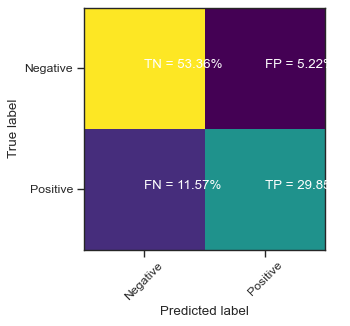

In [163]:
xgb_params = {
    #default
    "objective": "binary:logistic",
    "eta": 0.1,
    "verbosity": 0,
    "nthread": 3,
    "random_seed": 32,
    "eval_metric": "logloss",
    "use_label_encoder": False,
    "n_estimators":37,
    "max_depth": 5,
}

model, X_train, X_test, y_train, y_test = xgb_titanic(
    df, 
    remove_cols=['Embarked', 'Cabin', 'Title', 'HighSociety', ],
    xgb_params=xgb_params)


In [164]:
y = y_test
X = X_test
# ids_true = np.random.choice(y[y==1].index, size=200, replace=False)
# ids_false = np.random.choice(y[y==0].index, size=200, replace=False)
# X = X.loc[np.concatenate([ids_true, ids_false])]
explainer = shap.TreeExplainer(
    model, feature_names=X.columns)
shap_values = explainer.shap_values(X)

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.


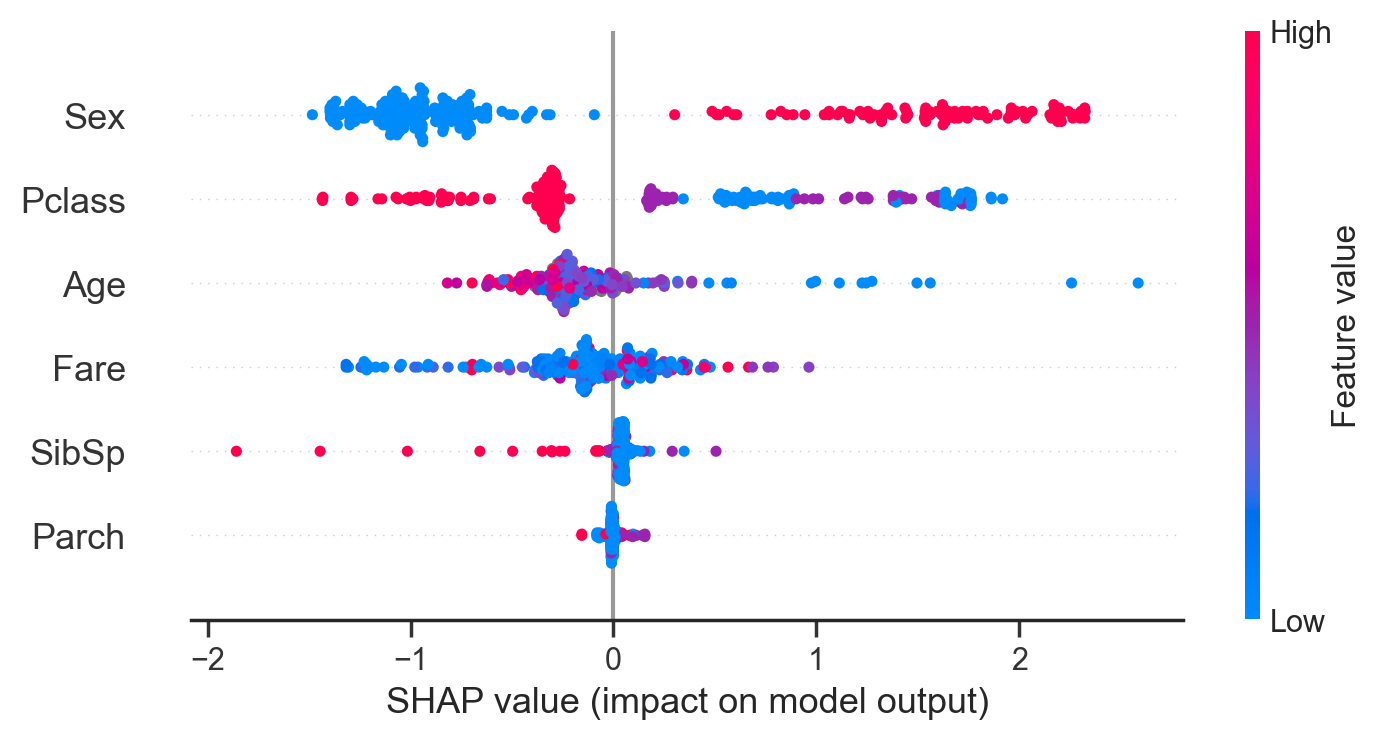

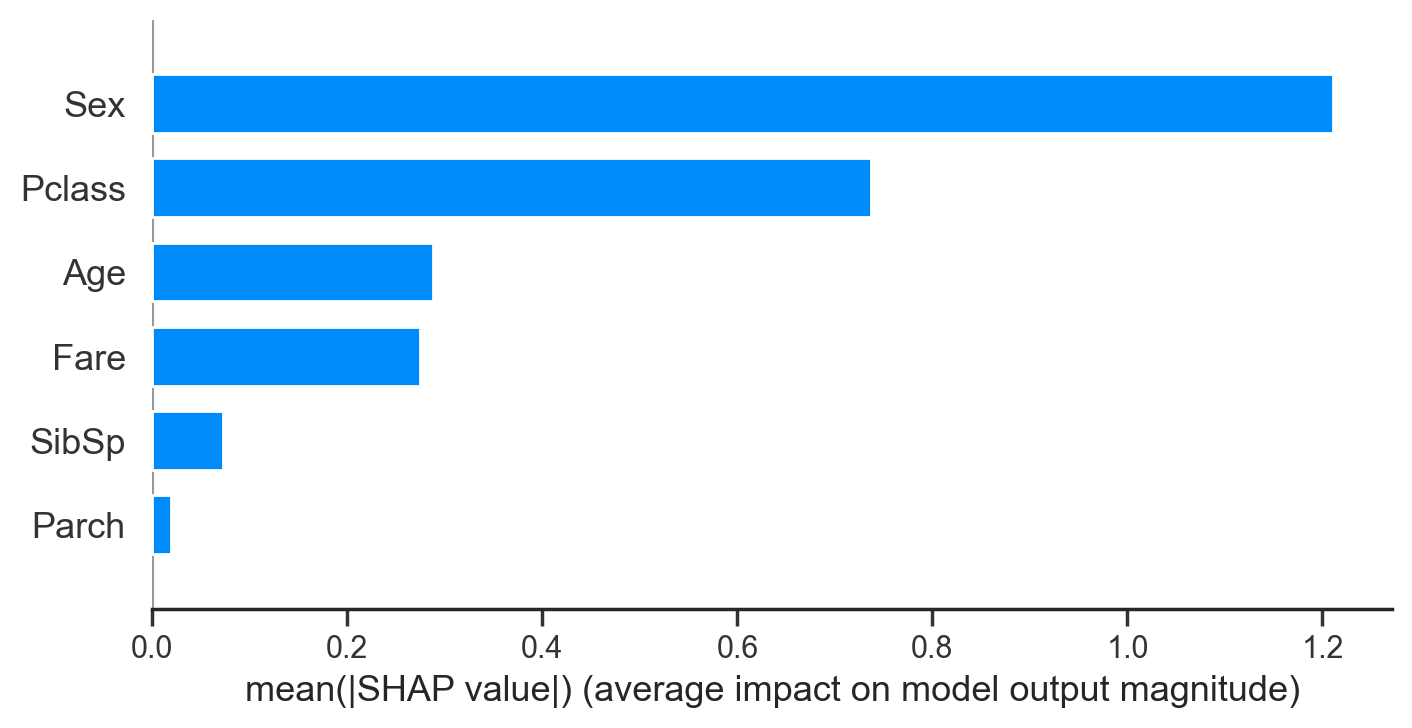

In [165]:
shap.summary_plot(shap_values, X)
shap.summary_plot(shap_values, X, plot_type="bar")



<Figure size 1800x1200 with 0 Axes>

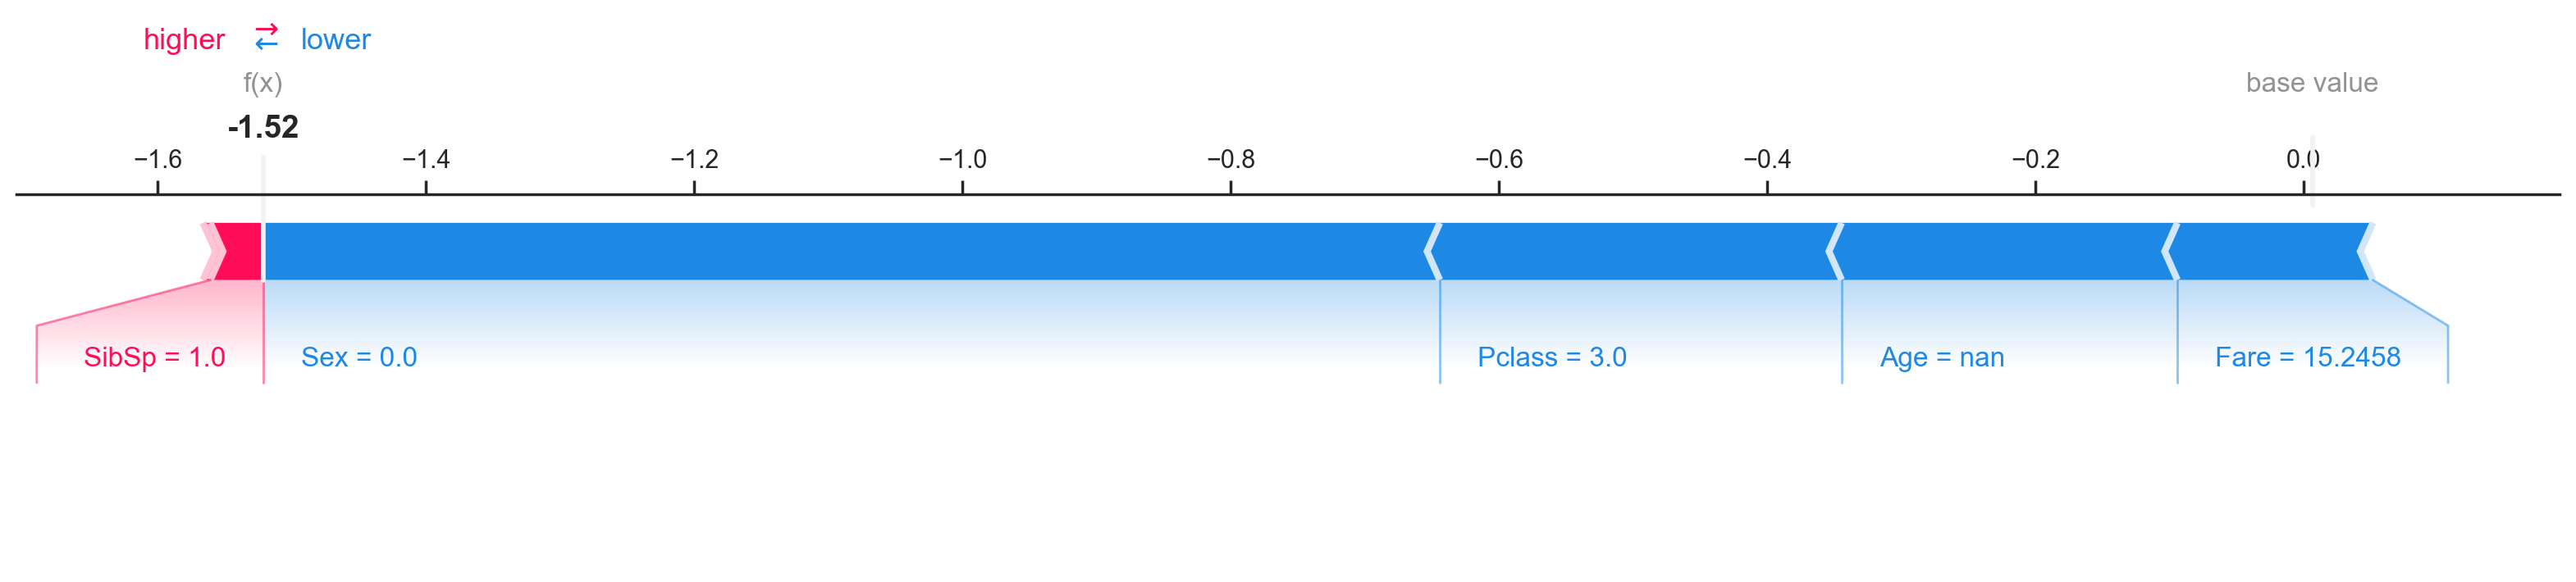

In [137]:

shap.force_plot(
    explainer.expected_value, shap_values[0,:], X.iloc[0,:],
    matplotlib=True, show=True)

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


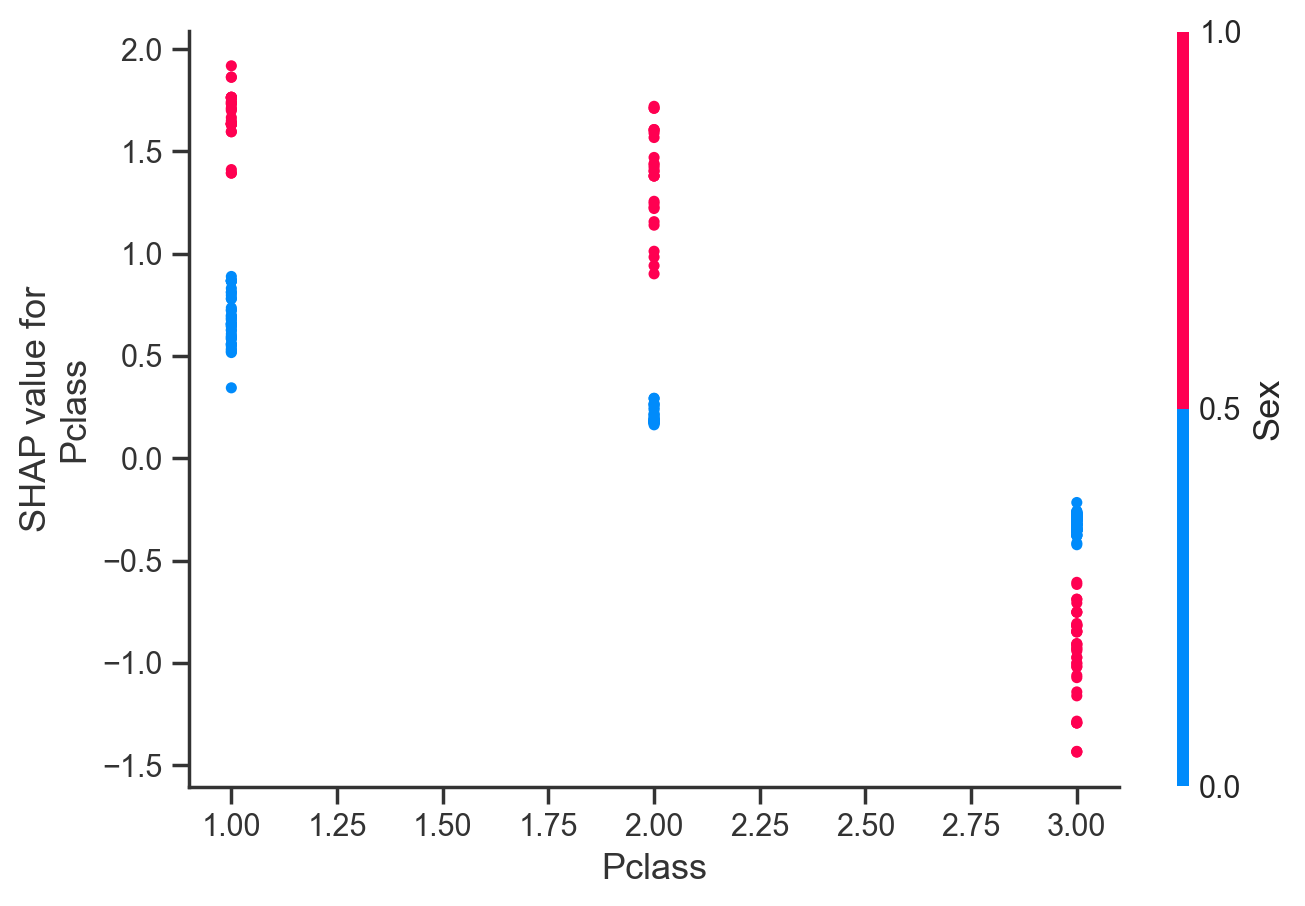

In [138]:
# check matplotlib version is 3.4.0
if matplotlib.__version__ == '3.4.0':
    shap.dependence_plot(
        "Pclass", shap_values, X_test, interaction_index="Sex")

In [139]:

def input_family(df):
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    df['IsAlone'] = 0
    df.loc[df['FamilySize'] == 1, 'IsAlone'] = 1

df_family = df.copy()
input_family(df_family)

Estimate: 1.70


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


### **XGBoost score**: $83.209\%$

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


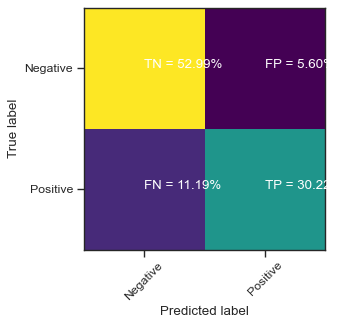

In [140]:


model, X_train, X_test, y_train, y_test = xgb_titanic(
    df_family, xgb_params=xgb_params, 
    knn_input=True,
    remove_cols=['Embarked', 'Cabin', 'Title',
    'SibSp', 'Parch', 'HighSociety'])

In [157]:


y = y_test 
X = X_test
# ids_true = np.random.choice(y[y==1].index, size=200, replace=False)
# ids_false = np.random.choice(y[y==0].index, size=200, replace=False)
# X = X.loc[np.concatenate([ids_true, ids_false])]

df_filtred = X[X['Age']>18]
#df_filtred = df_filtred[df_filtred['Age']<55]
explainer = shap.TreeExplainer(
    model, feature_names=X.columns)
shap_values = explainer.shap_values(df_filtred)

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.


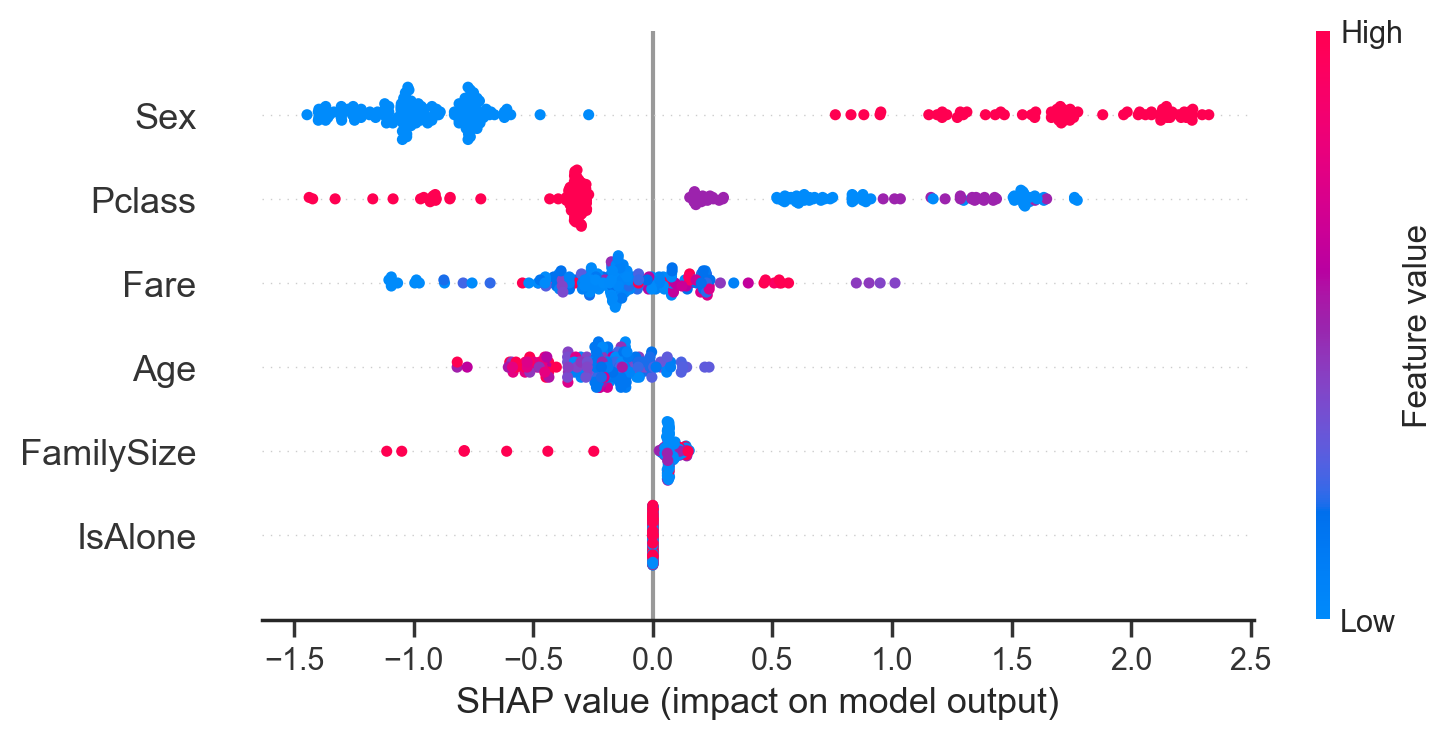

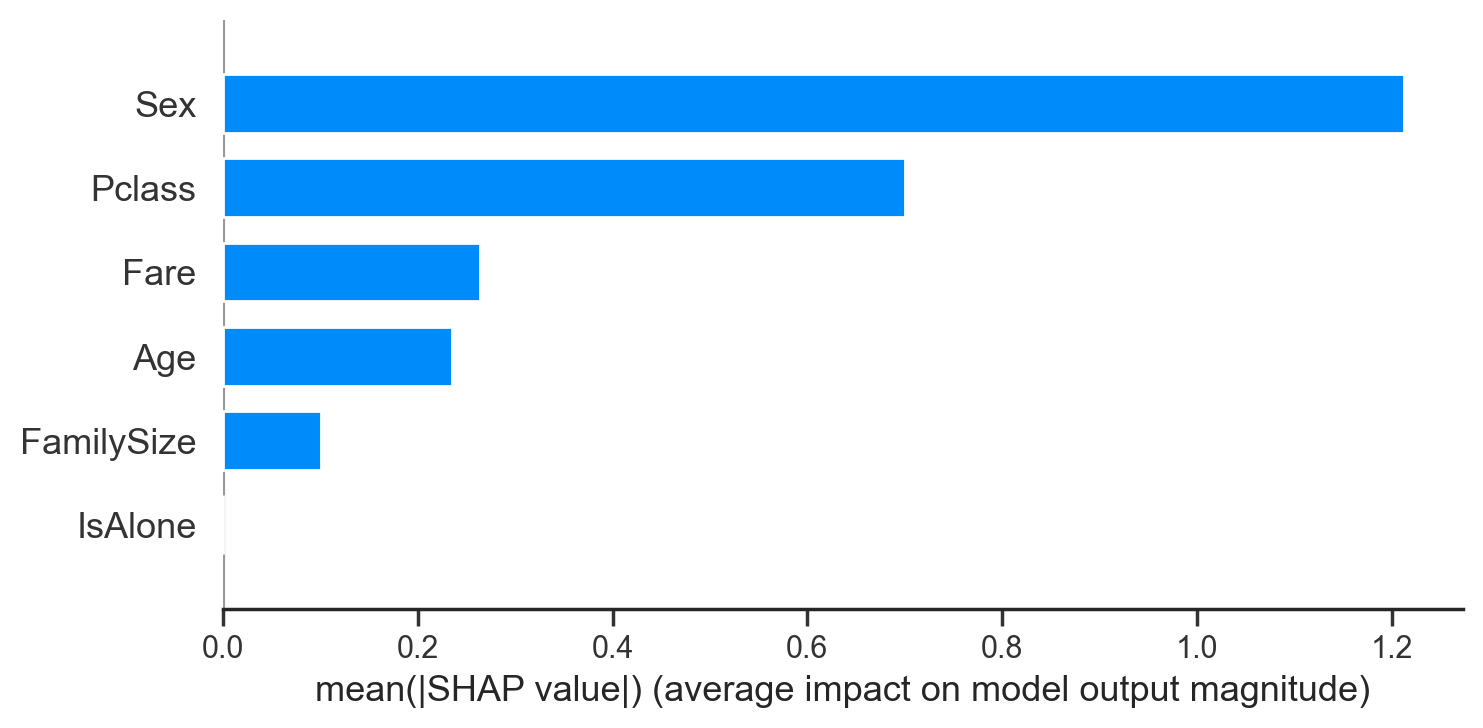

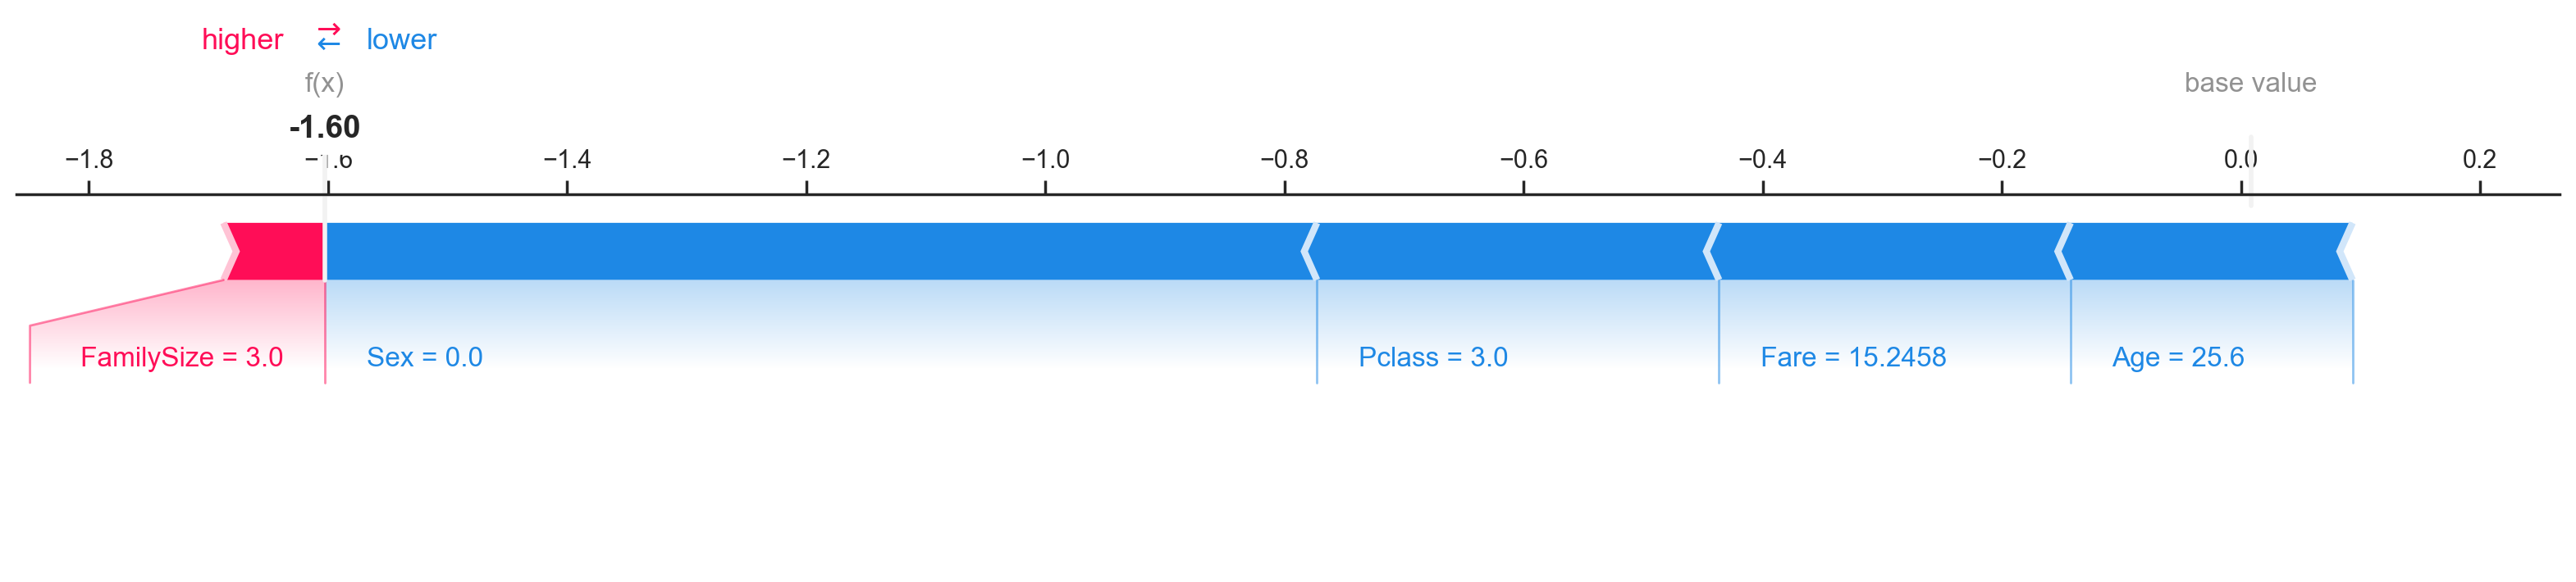

In [158]:

shap.summary_plot(shap_values, df_filtred)
shap.summary_plot(shap_values, df_filtred, plot_type="bar")
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:],  matplotlib=True, show=True)

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


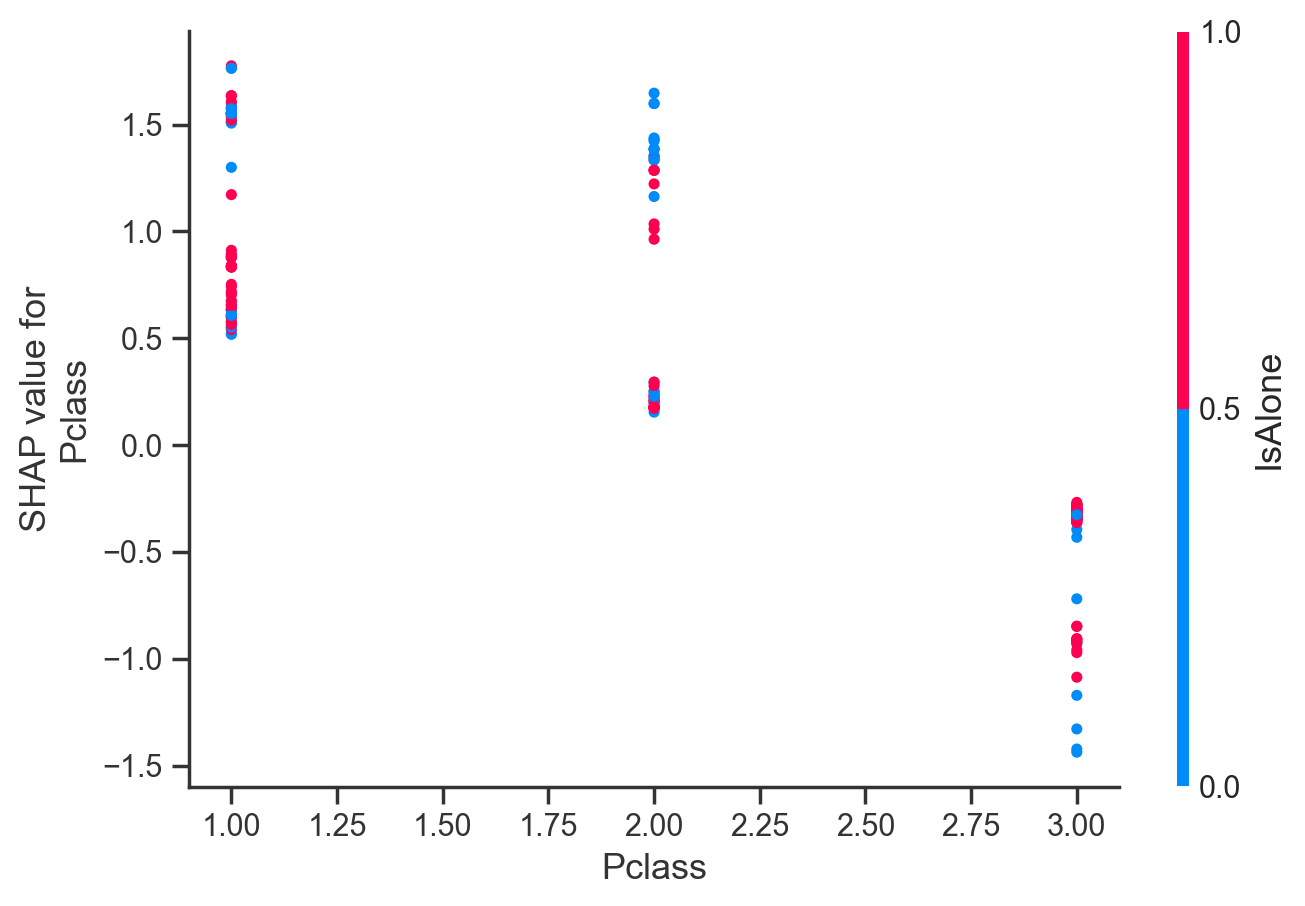

In [159]:
# check matplotlib version is 3.4.0
if matplotlib.__version__ == '3.4.0':
    shap.dependence_plot(
        "Pclass", shap_values, df_filtred, interaction_index="IsAlone")

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


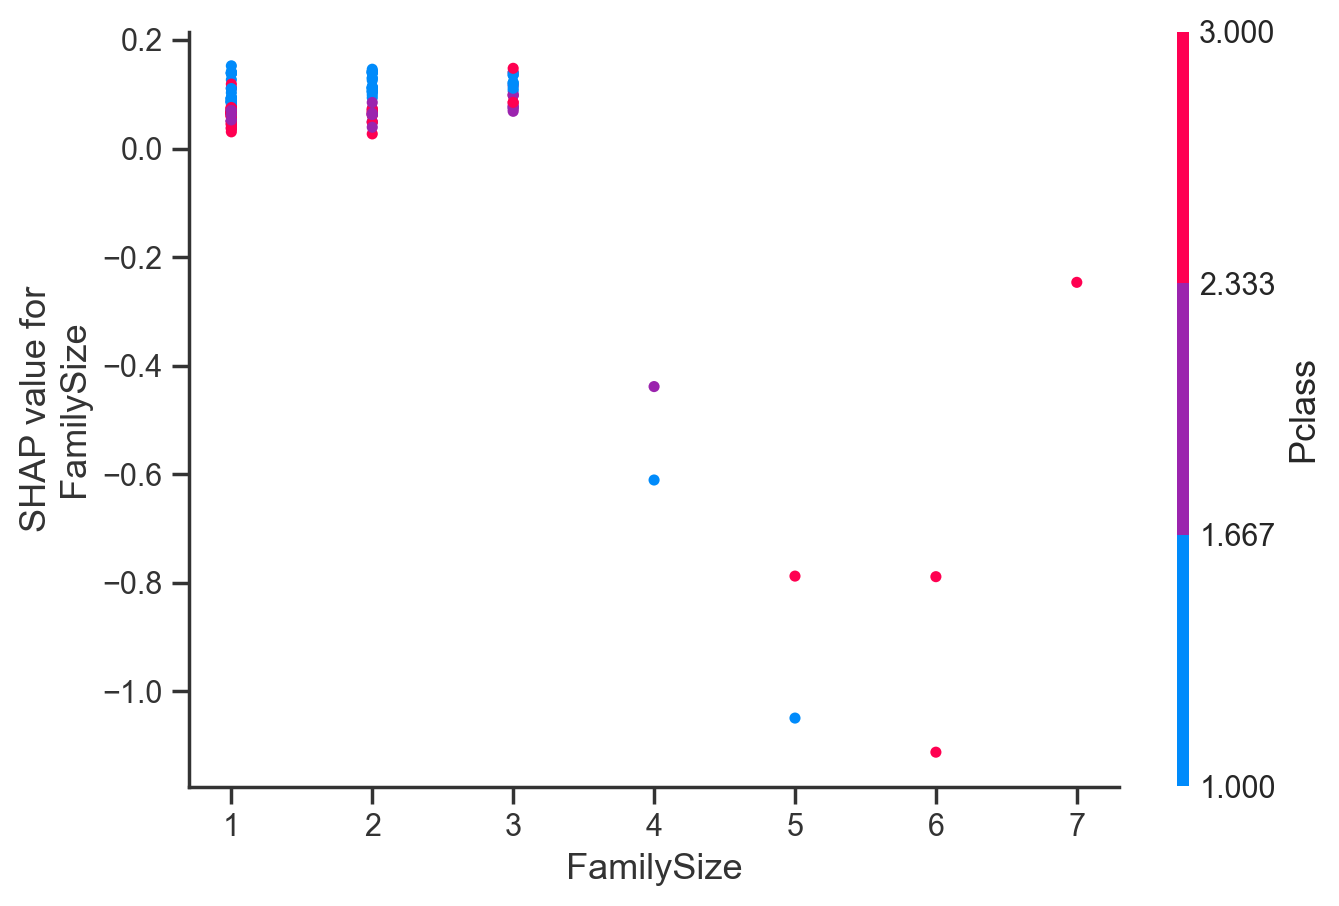

In [160]:
if matplotlib.__version__ == '3.4.0':
    shap.dependence_plot(
        "FamilySize", shap_values, df_filtred, interaction_index="Pclass")